In [24]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import sklearn.decomposition
import pickle
from sklearn.metrics import confusion_matrix

In [16]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('../results/confusion_matrix.png', bbox_inches='tight', transparent=True)

In [17]:
def utri2mat(utri):
    n = int(-1 + np.sqrt(1 + 8 * len(utri))) // 2
    iu1 = np.triu_indices(n+1,1)
    ret = np.empty((n+1, n+1))
    ret[iu1] = utri
    ret.T[iu1] = utri
    np.fill_diagonal(ret, 1)
    return ret

def pca_recon(FC, pctComp=None):
    '''
    Reconstructs FC based on number of principle components
    '''
    if pctComp is None:
        return FC
    nRegions = FC.shape[1]
    FC = np.reshape(FC, (FC.shape[0], -1))
    nComp = int(FC.shape[0] * pctComp)
    mu = np.mean(FC, axis=0)
    pca_rest = sklearn.decomposition.PCA()
    pca_rest.fit(FC)
    cumsum = np.cumsum(pca_rest.explained_variance_ratio_)
    SCORES = pca_rest.transform(FC)[:, :nComp]
    COEFFS = pca_rest.components_[:nComp, :]
    FC_recon = np.dot(SCORES, COEFFS)
    del SCORES, COEFFS
    FC_recon += mu
    FC_recon = np.reshape(FC_recon, (FC.shape[0], nRegions, nRegions))
    return FC_recon, cumsum

def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    for images, labels in loader:
        # Transfer to GPU
        if use_cuda:
            images, labels = images.to(device), labels.to(device)
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds


In [28]:
subjIDs = sio.loadmat('../data/SchaeferIDs.mat')['IDs']
subjIDs = [a[0] for a in subjIDs]
allIDs = sio.loadmat('../data/HCP_1113_subjInfo.mat')['subjInfo']
allIDs = pd.DataFrame(allIDs, columns=['ID', 'Gender', 'Age'])

,ID,Gender,Age
0,100206,0,27
1,100307,1,27
2,100408,0,33
3,100610,0,27
4,101006,1,35
...,...,...,...
1108,992774,0,35
1109,993675,1,29
1110,994273,0,30
1111,995174,0,25


In [15]:
parc = 200
with open(f'../data/schaefer{parc}.pickle', 'rb') as f:
    all_FC = pickle.load(f)
nSubj = int(all_FC.shape[0]/16)
nFCs = int(all_FC.shape[0])
all_FC, cumsum = pca_recon(all_FC, 0.01)

In [16]:
all_FC.shape

(6784, 214, 214)

## Deep Learning

In [17]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils import data
from sklearn.preprocessing import StandardScaler

# GPU is available? If so, we use it.
use_cuda = torch.cuda.is_available() 
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    print("GPU detected. Will use GPU for training!")
    torch.backends.cudnn.benchmark = True
else:
    print("No GPU detected. Will use CPU for training.")

No GPU detected. Will use CPU for training.


In [28]:
# Create labels corresponding to all_FC 
labels = torch.tensor(np.repeat(np.arange(0,8),nSubj*2), dtype=torch.long)
# Randomly shuffled indices for test FCs
indices = np.random.permutation(nFCs)
# Take subsets of data for training, validation, test
train_val_idx = indices[:int(0.8*nFCs)]

val_idx = train_val_idx[int(0.8*train_val_idx.shape[0]):]
train_idx = train_val_idx[:int(0.8*train_val_idx.shape[0])]
test_idx = indices[int(0.8*nFCs):]

In [19]:
train_mean = np.mean(all_FC[train_idx])
train_std = np.std(all_FC[train_idx])
train_data = torch.FloatTensor((all_FC[train_idx] - train_mean) / train_std)
val_data = torch.FloatTensor((all_FC[val_idx] - train_mean) / train_std)
test_data = torch.FloatTensor((all_FC[test_idx] - train_mean) / train_std)

In [20]:
train_data = train_data.view(train_data.shape[0], -1, train_data.shape[1], train_data.shape[2])
val_data = val_data.view(val_data.shape[0], -1, val_data.shape[1], val_data.shape[2])
test_data = test_data.view(test_data.shape[0], -1, test_data.shape[1], test_data.shape[2])

In [21]:
train_dataset = data.TensorDataset(train_data,labels[train_idx]) # create your datset
val_dataset = data.TensorDataset(val_data,labels[val_idx]) # create your datset
test_dataset = data.TensorDataset(test_data,labels[test_idx]) # create your datset

train_loader = data.DataLoader(train_dataset, batch_size=80) # create your dataloader
val_loader = data.DataLoader(val_dataset, batch_size=80) # create your dataloader
test_loader = data.DataLoader(test_dataset, batch_size=80) # create your dataloader


## NN Architecture

In [22]:
del all_FC
output_size = 8
max_epochs = 200
n_epochs_stop = 5

In [23]:
class Net(nn.Module):
    def __init__(self, nHidden):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=5)
        self.conv2_bn = nn.BatchNorm2d(12)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(nHidden, 128)
        self.fc2 = nn.Linear(128, 8)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (3,3)))
        x = F.relu(F.max_pool2d(self.conv2_bn(self.conv2(x)), (3,3)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

hidden_dict = {100: 1200, 200: 5808, 300: 13068, 400: 23232, 500: 36300}
model = Net(hidden_dict[parc])


In [24]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.001)
if use_cuda:
    model = model.cuda()
print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=5808, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=8, bias=True)
)


In [33]:
load_model = False
if load_model:
    model = Net(hidden_dict[parc])
    model.load_state_dict(torch.load("../trained_models/schaefer200_pca"))
    if use_cuda:
        model = model.cuda()
    print(model)

In [34]:
history = {}
history['loss'] = []
history['val_loss'] = []
history['acc'] = []
history['val_acc'] = []
min_val_loss = np.Inf
early_stop = False
# Loop over epochs


for epoch in range(max_epochs):
    # Training
    model.train()
    train_loss         = 0.0
    num_train_correct  = 0
    num_train_examples = 0
    for local_batch, local_labels in train_loader:
        # Transfer to GPU
        if use_cuda:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)



        opt.zero_grad()
        output = model(local_batch)
        loss = loss_fn(output, local_labels)
        loss.backward()
        opt.step()

        train_loss += loss.data.item() * local_batch.size(0)
        num_train_correct  += (torch.max(output, 1)[1] == local_labels).sum().item()
        num_train_examples += local_batch.shape[0]

    train_acc = num_train_correct / num_train_examples
    train_loss  = train_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss       = 0.0
    num_val_correct  = 0
    num_val_examples = 0
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in val_loader:
            # Transfer to GPU
            if use_cuda:
                local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            output = model(local_batch)
            loss = loss_fn(output, local_labels)

            val_loss += loss.data.item() * local_batch.size(0)
            num_val_correct  += (torch.max(output, 1)[1] == local_labels).sum().item()
            num_val_examples += local_batch.shape[0]

        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_loader.dataset)

        if val_loss < min_val_loss:
            epochs_no_improve = 0
            min_val_loss = val_loss
        else:
            epochs_no_improve += 1
  # Check early stopping condition
        if epochs_no_improve == n_epochs_stop:
            early_stop = print('Early stopping!')
            break

        
    print(f'Epoch {epoch+1}/{max_epochs}, train loss: {train_loss:5.4f}, train acc: {train_acc:5.3f}, val loss: {val_loss:5.3f}, val acc: {val_acc:5.3f}')
    
    
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    if early_stop:
        print("Stopped")
        break

Epoch 1/200, train loss: 1.5438, train acc: 0.566, val loss: 1.210, val acc: 0.630
Epoch 2/200, train loss: 0.9138, train acc: 0.819, val loss: 0.837, val acc: 0.755
Epoch 3/200, train loss: 0.6727, train acc: 0.863, val loss: 0.666, val acc: 0.819
Epoch 4/200, train loss: 0.5489, train acc: 0.888, val loss: 0.567, val acc: 0.852
Epoch 5/200, train loss: 0.4718, train acc: 0.906, val loss: 0.502, val acc: 0.863
Epoch 6/200, train loss: 0.4172, train acc: 0.915, val loss: 0.454, val acc: 0.880
Epoch 7/200, train loss: 0.3754, train acc: 0.925, val loss: 0.417, val acc: 0.892
Epoch 8/200, train loss: 0.3431, train acc: 0.932, val loss: 0.387, val acc: 0.898
Epoch 9/200, train loss: 0.3169, train acc: 0.939, val loss: 0.362, val acc: 0.905
Epoch 10/200, train loss: 0.2951, train acc: 0.942, val loss: 0.341, val acc: 0.909
Epoch 11/200, train loss: 0.2766, train acc: 0.946, val loss: 0.323, val acc: 0.913
Epoch 12/200, train loss: 0.2607, train acc: 0.948, val loss: 0.308, val acc: 0.919
E

In [35]:
local_batch.device

device(type='cuda', index=0)

In [36]:
torch.save(model.state_dict(), "../trained_models/schaefer200_pca")

In [37]:
model.eval()
num_correct  = 0
num_examples = 0
with torch.set_grad_enabled(False):
    for local_batch, local_labels in test_loader:
        # Transfer to GPU
        if use_cuda:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        output = model(local_batch)
        num_correct  += (torch.max(output, 1)[1] == local_labels).sum().item()
        num_examples += local_batch.shape[0]
            
    test_acc  = num_correct / num_examples

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


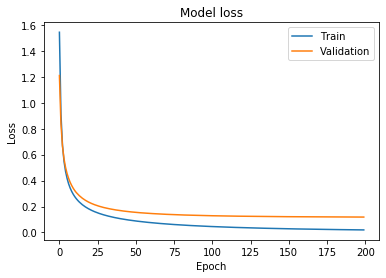

In [38]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('../results/train_loss_curve.eps', bbox_inches='tight', transparent=True)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


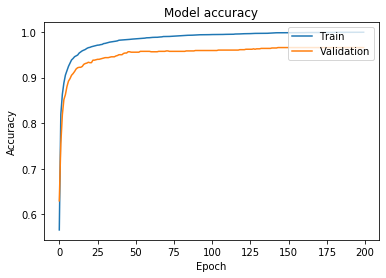

In [39]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('../results/train_val_accuracy.eps', bbox_inches='tight', transparent=True)
plt.show()

In [40]:
test_acc

0.9557848194546794

In [41]:
test_labels = labels[test_idx]
with torch.set_grad_enabled(False):
    test_preds = get_all_preds(model, test_loader)

In [42]:
stacked = torch.stack((test_labels.to(device), test_preds.argmax(dim=1)),dim=1)

In [43]:
cmt = torch.zeros(8,8,dtype=torch.int64)

In [44]:
for p in stacked:
    tl,pl = p.tolist()
    cmt[tl,pl] = cmt[tl,pl] + 1

In [45]:
cm = confusion_matrix(test_labels.cpu(), test_preds.cpu().argmax(dim=1))

Confusion matrix, without normalization
[[180   1   0   0   0   0   0   0]
 [  0 152   3   1   0   3   1   2]
 [  0   8 155   1   1   5   1   4]
 [  0   0   0 167   2   0   0   0]
 [  1   1   0   1 167   0   0   0]
 [  0   2   0   0   1 148   0   6]
 [  0   1   0   2   0   0 166   1]
 [  0   1   0   0   0   8   2 162]]


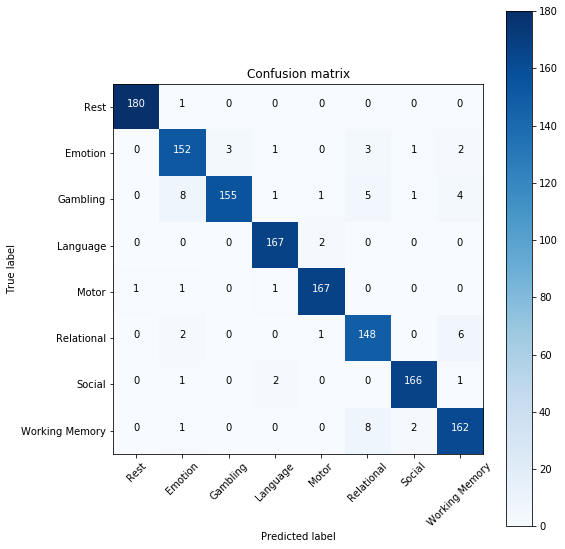

In [46]:
names = ('Rest', 'Emotion', 'Gambling', 'Language', 'Motor', 'Relational', 'Social', 'Working Memory')
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, names)